In [1]:
import pandas as pd
import os
data = pd.read_csv('data_w_subj.csv')
data

FileNotFoundError: [Errno 2] No such file or directory: 'data_w_subj.csv'

In [2]:
# Split the subjects column by comma and select the first subject only
data['subjects'] = data['subjects'].str.split(',').str[0]

# Save the modified data to a new CSV file
data.to_csv('modified_data.csv', index=False)

In [3]:
data = pd.read_csv('modified_data.csv')
data

,Unnamed: 0,author_id,author_name,book_id,gutenbergbookid,title,text,text_lines,subjects
0,0,5959,"Sharkey, John Michael",3670,33871,Old Friends Are the Best,"['', '', '', 'CHAPTER VIII.', '', 'JAMES TRIPL...",3693,['Science fiction'
1,1,5959,"Sharkey, John Michael",3670,33871,Old Friends Are the Best,"['life;"" and her shoulders went up to her ears...",1643,['Science fiction'
2,2,5959,"Sharkey, John Michael",3670,33871,Old Friends Are the Best,"['various talents, and are come to make a dema...",4143,['Science fiction'
3,3,5959,"Sharkey, John Michael",3670,33871,Old Friends Are the Best,"['would be a lasting discredit,"" she continued...",3393,['Science fiction'
4,4,5959,"Sharkey, John Michael",3670,33871,Old Friends Are the Best,['homely which he invented in our first chapte...,2693,['Science fiction'
...,...,...,...,...,...,...,...,...,...
2439,2439,7150,"Blish, James",62429,59415,To Pay the Piper,"['Pneumococcus I in 2 instances, Pneumococcus ...",10479,['Science fiction'
2440,2440,7150,"Blish, James",62429,59415,To Pay the Piper,[' pleurisy │ │ │ │ ...,12329,['Science fiction'
2441,2441,7150,"Blish, James",62429,59415,To Pay the Piper,['influenzæ. Repeated throat cultures were not...,14679,['Science fiction'
2442,2442,7150,"Blish, James",62429,59415,To Pay the Piper,"[' and Pneumonia',...",5129,['Science fiction'


In [5]:
import re

# Remove punctuation
data['text_processed'] = data['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Convert to lowercase
data['text_processed'] = data['text_processed'].apply(lambda x: x.lower())

data.head()

,Unnamed: 0,author_id,author_name,book_id,gutenbergbookid,title,text,text_lines,subjects,text_processed
0,0,5959,"Sharkey, John Michael",3670,33871,Old Friends Are the Best,"['', '', '', 'CHAPTER VIII.', '', 'JAMES TRIPL...",3693,['Science fiction',chapter viii james triplet water in his ey...
1,1,5959,"Sharkey, John Michael",3670,33871,Old Friends Are the Best,"['life;"" and her shoulders went up to her ears...",1643,['Science fiction',life and her shoulders went up to her earsthen...
2,2,5959,"Sharkey, John Michael",3670,33871,Old Friends Are the Best,"['various talents, and are come to make a dema...",4143,['Science fiction',various talents and are come to make a demand ...
3,3,5959,"Sharkey, John Michael",3670,33871,Old Friends Are the Best,"['would be a lasting discredit,"" she continued...",3393,['Science fiction',would be a lasting discredit she continued and...
4,4,5959,"Sharkey, John Michael",3670,33871,Old Friends Are the Best,['homely which he invented in our first chapte...,2693,['Science fiction',homely which he invented in our first chapter ...


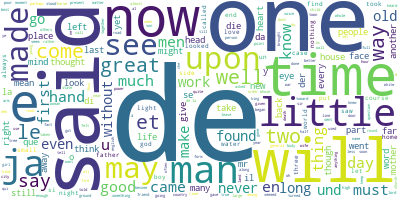

In [6]:
from wordcloud import WordCloud

# Join together
long_string = ','.join(list(data['text_processed'].values))

# Generate a wordCloud
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)

# Visualize
wordcloud.to_image()

In [7]:
# Get number of unique subjects
num_subjects = data['subjects'].nunique()
num_subjects

148

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import accuracy_score

# Split data into train/validation/test sets with a ratio of 70/15/15
train, test = train_test_split(data, test_size=0.3, random_state=42)
val, test = train_test_split(test, test_size=0.5, random_state=42)

# Preprocess text data - remove stop_words
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(train['text_processed'])
X_val = vectorizer.transform(val['text_processed'])
X_test = vectorizer.transform(test['text_processed'])

# Train LDA model
lda = LatentDirichletAllocation(n_components=145) 
                                #,max_iter=50, learning_method='online', random_state=42
lda.fit(X_train)

# Predict subject for documents in validation set
y_val = lda.transform(X_val)

# Predict subject for documents in test set
y_test = lda.transform(X_test)

# Convert subject column to numerical labels
labels_train = pd.factorize(train['subjects'])[0]
labels_val = pd.factorize(val['subjects'])[0]
labels_test = pd.factorize(test['subjects'])[0]

# Train a classifier on the LDA topics
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(y_val, labels_val)

# Evaluate performance on the validation set
pred_val = clf.predict(y_val)
acc_val = accuracy_score(labels_val, pred_val)
print('Accuracy on validation set:', acc_val)

# Evaluate performance on the test set
pred_test = clf.predict(y_test)
acc_test = accuracy_score(labels_test, pred_test)
print('Accuracy on test set:', acc_test)

Accuracy on validation set: 0.08719346049046321
Accuracy on test set: 0.0326975476839237
